In [2]:
print("Importing voice data. {}".format(datetime.now()))
train_voice_filenames = get_filenames(voice_train_path)
train_voice_filenames_small = train_voice_filenames[:20]

Importing voice data. 2019-11-30 19:59:34.557704


In [3]:
train_dataset_small = voice_face(train_voice_filenames_small, standardize=True)
dataloader_small = DataLoader(train_dataset_small, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
print("Importing face data as vectors into a dictionary. {}".format(datetime.now()))
face_dict = make_face_dict(path=face_path, face_std=FACE_STD)

Importing face data as vectors into a dictionary. 2019-11-30 19:59:41.124115


In [5]:
# train AE_model and save outputs
print("Loading Voice Autoencoder model. {}".format(datetime.now()))
AE_model = Voice_Autoencoder()
AE_optimizer = torch.optim.Adam(AE_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
AE_NUM_EPOCHS = 1    

AE_loss_epochs = []
for epoch in range(AE_NUM_EPOCHS):
    for batch in dataloader_small:
        # ===================forward=====================
        voice_data, IDs = batch
        voice_outputs, w = AE_model(voice_data)
        loss = voice_loss(voice_outputs, voice_data)
        # ===================backward====================
        AE_optimizer.zero_grad()
        loss.backward()
        AE_optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}, completed at {}'
        .format(epoch+1, AE_NUM_EPOCHS, loss.data.item(), datetime.now()))
    AE_loss_epochs.append(loss)

Loading Voice Autoencoder model. 2019-11-30 19:59:58.170878
epoch [1/1], loss:1.0068, completed at 2019-11-30 20:00:02.754139


In [6]:
save_state("./AE_model_state_test.pth", AE_model, AE_optimizer, [999])

In [7]:
load_state("./AE_model_state_test.pth", AE_model, AE_optimizer, print_model=True)

Voice_Autoencoder(
  (encoder): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): ModuleList(
    (0): ConvTranspose2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 0), output_padding=(1, 0))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 0))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2))
    (7): Tanh()
  )
)


Training model. 2019-11-30 20:00:02.853967
epoch [1/5], loss:71.1590, completed at 2019-11-30 20:00:13.609680
epoch [2/5], loss:71.6423, completed at 2019-11-30 20:00:23.131340
epoch [3/5], loss:72.3622, completed at 2019-11-30 20:00:31.883072
epoch [4/5], loss:71.4289, completed at 2019-11-30 20:00:39.796161
epoch [5/5], loss:71.3141, completed at 2019-11-30 20:00:48.452817


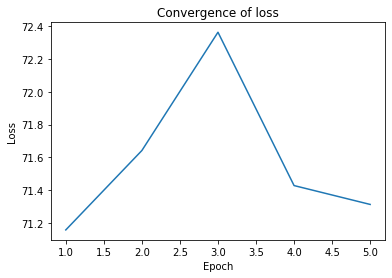

In [8]:
print("Training model. {}".format(datetime.now()))
model = full_model(AE_model, face_shape=(128,128))
if CUDA:
    model = model.cuda()
train_model(model, dataloader_small, face_dict)

In [9]:
# pick an ID to predict (can be int or tensor)
predict_ID = train_dataset_small.y[0]
predict_ID

tensor(127)

In [10]:
predict_face = model.predict(ID=predict_ID, voice_filepath="data/Voice_to_face/voicespecs/")

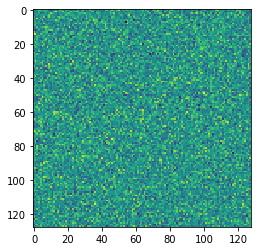

In [11]:
plt.imshow(predict_face) # terrible b/c only 20 voice files used

In [ ]:
# evaluation task
from V2F_eval_task import evaluate_model
validate_IDs = train_dataset_small.y[:5]
top_n_acc = evaluate_model(model, evaluate_IDs=validate_IDs, voice_eval_path="data/Voice_to_face/voicespecs/", 
                           face_dict=face_dict, lineup_length=5)

In [ ]:
top_n_acc = ranks

In [ ]:
from V2F_eval_task import plot_top_n_acc
plot_top_n_acc(top_n_acc)

Start validating model. 2019-11-30 20:01:05.146529
Evaluation number 1 of 5: ID=127 was rank 2/10. 2019-11-30 20:01:21.097095
Evaluation number 2 of 5: ID=120 was rank 1/10. 2019-11-30 20:01:39.761383
Evaluation number 3 of 5: ID=129 was rank 8/10. 2019-11-30 20:01:54.739890
Evaluation number 4 of 5: ID=175 was rank 3/10. 2019-11-30 20:02:13.471206
Evaluation number 5 of 5: ID=161 was rank 5/10. 2019-11-30 20:02:42.897027


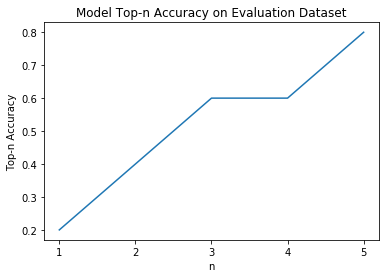

In [12]:
print("Start validating model. {}".format(datetime.now()))
top_n_acc = evaluate_model(model, 
                           evaluate_IDs=validation_IDs, 
                           voice_eval_path=validation_voice_filepath, 
                           face_dict=face_dict, 
                           lineup_length=lineup_length,
                           save=True)
plot_top_n_acc(top_n_acc, save=True)

In [1]:
"""
Script for training a given model architecture
v0.5 November 30, 2019

Script to train a voice to voice+face model for given hyperparameters and a 
given (trained) voice autoencoder.
Then runs an evaluation routine on the trained model and saves the results.

INPUTS:
- a trained voice autoencoder - edit AE_save_state to be the filepath of its save state 
- edit the hyperparameters listed before the main function definition
- note: provide the training voice data ONLY, not the voices for any IDs in the 
        validation or test sets, as we do not want the model to see any 
        validation or test set faces.
OUTPUTS:
- saves the full model model state at "./model_state.pth"
- saves the convergence plot and list of loss at each iteration in a folder named "./convergence"
"""

import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt
# import validation functions
from V2F_eval_task import evaluate_model
from V2F_eval_task import plot_top_n_acc

# HS TODO tonight
# give MY and JZ instructions for getting access to GCP and requesting high performance GPUs
# upload full data to drive
# start training voice AE tonight

# MY TODO tonight
# sign up for GCP and request approval for high performance GPUs
# think of solution for face MSE being huge because its std is not 1.

# JZ TODO tonight or asap tomorrow
# - sign up for GCP and request approval for high performance GPUs
# - ensure evaluation task can take a list of (reconstructed) face matrices, 
#       and list of IDs, and output an evaluation metric / list of evaluation metrics
#       you can assume that a face_dict will be provided where face_dict[ID] returns
#       the true face matrix associated with the ID.
# - think about what chart(s) we can show on the results section of the poster for the evaluation.

# TODO this weekend
# - manually separate train, validate, test IDs and put them in separate folders
# - write a predict function that averages the reconstructed face for all voice clips belonging to ID
# - load each model state and get eval_metric on the evaluation task
# - pick the model/hyperparams that yields best eval_metric
# - optional: train model using best hyperparams on train+validate data
# - get eval_metric of the best model using the test data


# Training parameters
ALPHA = 0.5
ORTHOGONALIZE_B = True
NUM_EPOCHS = 5
BATCH_SIZE = 10
voice_loss = nn.MSELoss()
face_loss = nn.MSELoss()
FACE_STD = 28 # std dev of pixel values from a subsample of 93 faces. used to scale faces to have std ~= 1
LEARNING_RATE = 1e-3
CUDA = False
voice_train_path = "data/Voice_to_face/voicespecs/"
face_path = "data/Voice_to_face/facespecs/"
AE_save_state = "./AE_model_state_test.pth"

# Validation parameters
validation_IDs = [127, 120, 129, 175, 161] # TODO determine this
validation_voice_filepath = "data/Voice_to_face/voicespecs/" # TODO determine this
lineup_length = 10

# # EITHER EDIT THIS CLASS OR IMPORT IT FROM YOUR OWN SCRIPT
class Voice_Autoencoder(nn.Module):
    def __init__(self):
        """
        w_length: the length of the bottleneck vector i.e. # of basis faces used
        face_length: the height * width of the face images
        """
        super(Voice_Autoencoder, self).__init__()
        
        self.w_length = None
        
        self.encoder = nn.ModuleList(
            [
                nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1), #1025 x 251
                nn.ReLU(True),
                #nn.MaxPool2d(2, stride=2), 
                nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=0), #512 x 125
                nn.ReLU(True),
                #nn.MaxPool2d(2, stride=2),
                nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), #256 x 63
                nn.ReLU(True),
                nn.MaxPool2d(2, stride=2),                             #128 x 31
                nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)   #128 x 31
            ]
        )
        
        self.decoder = nn.ModuleList(
            [
                nn.ConvTranspose2d(1, 32, kernel_size=3, stride=1, padding=1), # 128 x 31
                nn.ReLU(True),
                nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=(1,0), output_padding = (1,0)), # 256 x 63
                nn.ReLU(True),
                nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=(1,1), output_padding = (1,0)), # 512 x 125
                nn.ReLU(True),
                nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=0, output_padding = 0), # 1025 x 251
                nn.Tanh()
            ]
        )

    def forward(self, v):
        # start encoder
        for layer in self.encoder:
            v = layer.forward(v)
            #print(v.shape)
        
        # collapse final feature map into a vector by taking average across time
        N, _, H, _ = v.shape
        w = v.mean(dim=3)
        w = w.view(N, H)
        
        if self.w_length == None:
            self.w_length = H
        
        # start decoder
        for layer in self.decoder:
            v = layer.forward(v)
            #print(v.shape)
        
        return v, w


# # EXAMPLE CODE FOR TRAINING VOICE AUTOENCODER
# print("Importing voice data. {}".format(datetime.now()))
# train_dataset, dataloader = prep_data()
# print("Importing face data as vectors into a dictionary. {}".format(datetime.now()))
# face_dict = make_face_dict(path=face_path, face_std=FACE_STD)

# AE_model = Voice_Autoencoder()
# AE_optimizer = torch.optim.Adam(AE_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
# AE_NUM_EPOCHS = 100

# AE_loss_epochs = []
# for epoch in range(AE_NUM_EPOCHS):
#     for batch in dataloader:
#         # ===================forward=====================
#         voice_data, IDs = batch
#         voice_outputs, w = AE_model(voice_data)
#         loss = voice_loss(voice_outputs, voice_data)
#         # ===================backward====================
#         AE_optimizer.zero_grad()
#         loss.backward()
#         AE_optimizer.step()
#     # ===================log========================
#     print('epoch [{}/{}], loss:{:.4f}, completed at {}'
#         .format(epoch+1, AE_NUM_EPOCHS, loss.data.item(), datetime.now()))
#     AE_loss_epochs.append(loss)
# save_state("./AE_model_state_test.pth", AE_model, AE_optimizer, AE_loss_epochs)



def main():
    print("Importing voice data. {}".format(datetime.now()))
    train_dataset, dataloader = prep_data()

    print("Importing face data as vectors into a dictionary. {}".format(datetime.now()))
    face_dict = make_face_dict(path=face_path, face_std=FACE_STD)
    
    # train model and save outputs
    print("Loading Voice Autoencoder model. {}".format(datetime.now()))
    AE_model = Voice_Autoencoder()
    AE_optimizer = torch.optim.Adam(AE_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    load_state(AE_save_state, AE_model, AE_optimizer, print_model=True)
    # AE_model = TODO LOAD MODEL

    print("Training model. {}".format(datetime.now()))
    model = full_model(AE_model, face_shape=(128,128))
    if CUDA:
        model = model.cuda()
    train_model(model, dataloader, face_dict)
    print("Model training complete. {}".format(datetime.now()))

    print("Start validating model. {}".format(datetime.now()))
    top_n_acc = evaluate_model(model, 
                               evaluate_IDs=validation_IDs, 
                               voice_eval_path=validation_voice_filepath, 
                               face_dict=face_dict, 
                               lineup_length=lineup_length,
                               save=True)
    plot_top_n_acc(top_n_acc, save=True)
    print("Validation complete. {}".format(datetime.now()))


class full_model(nn.Module):
    def __init__(self, AE_model, face_shape=(128,128)):
        """
        AE_model: a voice autoencoder model whose forward function returns v, w,
                  where v is the voice reconstruction and w is the embedding
        face_length: the height * width of the face images
        """
        super(full_model, self).__init__()
        self.AE_model = AE_model
        self.w_length = AE_model.w_length
        self.face_length = face_shape[0] * face_shape[1]
        self.B = nn.Linear(self.w_length, self.face_length, bias=False)

    def forward(self, v):
        # run voice input through AE
        v, w = self.AE_model(v)
        
        # face construction
        f = self.B(w)
        
        return v, f

    def predict(self, ID, voice_filepath, face_std=FACE_STD, standardize=True):
        if type(ID) == torch.Tensor:
            ID = ID.item()
        # get all voice files that correspond to that ID
        format = "voice_{}*".format(ID)
        voice_filenames = get_filenames(voice_filepath, filename_format=format)
        assert(len(voice_filenames) > 0)

        # construct spectrograms tensor
        matrices = [] # the spectrograms
        for v_file in voice_filenames:
            # get spectrogram
            matrix = np.loadtxt(v_file, delimiter=',', dtype=np.float32)
            if standardize:
                matrix = (matrix - np.mean(matrix)) / np.std(matrix)
            matrices.append(matrix)
        voices_tensor = torch.Tensor(matrices)
        N, D, M = voices_tensor.shape
        voices_tensor = voices_tensor.view(N, 1, D, M) # insert channel dimension

        # get average of the face reconstructions as a 2D numpy array
        _, f = self.forward(voices_tensor) # reconstruct face from every voice
        f_mean = f.mean(dim=0) # get the average of all the reconstructed faces
        f_mean = f_mean.detach().numpy() # convert to numpy array
        f_mean = f_mean.reshape((128,128))
        f_mean = f_mean * face_std # scale back up
        return f_mean


def prep_data():
    train_voice_filenames = get_filenames(voice_train_path)
    train_dataset = voice_face(train_voice_filenames, standardize=True)
    dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    return train_dataset, dataloader


def make_face_dict(path=face_path, face_std=FACE_STD, IDs=None):
    """
    USAGE: 
    - face_dict[6] returns a 2D numpy array of the face with ID=6
    INPUTS:
    - IDs: a 1D tensor or iterable of int IDs
    - path: a filename format with {} in place of the ID in the filename.
    """
    face_dict = {}
    if IDs == None:
        f_files = get_filenames(path, filename_format="face_*")
        for f_file in f_files:
            ID = get_n(f_file)
            face_arr = np.loadtxt(f_file, delimiter=',').flatten()
            face_arr = face_arr / face_std # scale to have std dev ~= 1
            face_dict[ID] = face_arr
    else:
        if path[-1] != '/':
            path += '/'
        
        for ID in IDs:
            if type(ID) == torch.Tensor:
                ID = ID.item()
            assert(type(ID) == int)
            
            f_file = path + "face_{}.csv".format(ID)
            face_arr = np.loadtxt(f_file, delimiter=',').flatten()
            face_arr = face_arr / face_std # scale to have std dev ~= 1
            face_dict[ID] = face_arr
    return face_dict


def get_filenames(paths, filename_format="voice_*"):
    # in case only one path given, make it a list so that it's iterable
    if type(paths) == str:
        paths = [paths]

    # get lists of all voice filenames
    filenames = []
    for path in paths:
        if path[-1] != '/':
            path += '/'
        filenames += glob(path + filename_format)
   
    return filenames


class voice_face(Dataset):
    def __init__(self, voice_filenames, standardize=False):
        """
        Preconditions: csv files must contain matrices of the same dimension
        Args:
            voice_filenames (string or list): list of filenames/pathnames of csv files with spectrogram matrices
                                              assumes format voice_{n}_{m}.csv, 
                                              where n is the data ID and m is the spectrogram number for that speaker
            standardise (boolean):            whether to standardize the spectrograms
        """
        # ensure inputs are lists
        if type(voice_filenames) == str:
            voice_filenames = [voice_filenames]
        assert(type(voice_filenames) == list)
                
        # load voice spectrograms one by one
        face_IDs = [] # the face IDs associated with each spectrogram
        matrices = [] # the spectrograms
        for v_file in voice_filenames:
            # get n, the data ID 
            n, _ = get_n_m(v_file)
            face_IDs.append(n)
            
            # get spectrogram
            matrix = np.loadtxt(v_file, delimiter=',', dtype=np.float32)
            if standardize:
                matrix = (matrix - np.mean(matrix)) / np.std(matrix)
            matrices.append(matrix)
        
        # construct spectrograms tensor
        self.X = torch.Tensor(matrices)
        N, D, M = self.X.shape
        self.X = self.X.view(N, 1, D, M) # insert channel dimension
        
        # construct face_IDs tensor
        self.y = torch.tensor(face_IDs)
        
        assert(self.X.shape[0] == self.y.shape[0])
        
    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def get_n_m(v_file):
    """
    Takes a voice file name of the form path/voice_{n}_{m}.csv
    And outputs n and m as integers.
    """
    v_file = v_file.split('/')[-1] # strip the pathname if it exists
    v_file, _ = v_file.split('.') # strip the file extension
    _, n, m = v_file.split('_') # get n and m from the filename
    return int(n), int(m)


def get_n(f_file):
    """
    Takes a face file name of the form path/face_{n}.csv
    And outputs n as an integer.
    """
    f_file = f_file.split('/')[-1] # strip the pathname if it exists
    f_file, _ = f_file.split('.') # strip the file extension
    _, n = f_file.split('_') # get n from the filename
    return int(n)

def combined_loss(model_output, labels, face_dict):
    """
    REQUIRES
    - face dictionary
    - face_retrieve_loss function
    INPUTS
    - model_output: a tuple of (voice_output, face_output), both tensors
    - labels: a tuple of (voice_data, face_id), a tensor and a 1-D tensor
    """
    # unpack input
    voice_outputs, face_outputs = model_output
    voice_data, IDs = labels
    
    # compute combined loss
    combined_loss = face_retrieve_loss(face_outputs, IDs, face_dict) + ALPHA * voice_loss(voice_outputs, voice_data)
    return combined_loss


def face_retrieve_loss(face_outputs, IDs, face_dict):
    """
    Retrieves ground truth face tensor given the IDs, computes and returns loss
    REQUIRES
    - face dictionary
    - face_loss function
    INPUTS
    - face_outputs: tensor of face matrices
    - IDs: tensor of IDs
    """
    # construct true faces tensor
    true_faces = []
    for ID in IDs:
        ID_int = ID.item()
        true_faces.append(face_dict[ID_int])
    true_faces = torch.Tensor(true_faces)

    # compute and return loss
    loss = face_loss(face_outputs, true_faces)
    return loss

def train_model(model, dataloader, face_dict):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    
    loss_epochs = []
    for epoch in range(NUM_EPOCHS):
        for batch in dataloader:
            # ===================forward=====================
            voice_data, IDs = batch
            # voice_outputs, face_outputs = model(voice_data)
            loss = combined_loss(model(voice_data), batch, face_dict)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if ORTHOGONALIZE_B:
                model.B.weight.data = gram_schmidt(model.B.weight.data)
        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}, completed at {}'
            .format(epoch+1, NUM_EPOCHS, loss.data.item(), datetime.now()))
        loss_epochs.append(loss)

    save_state("./model_state.pth", model, optimizer, loss_epochs)
    np.savetxt("./convergence_loss.csv", loss_epochs, delimiter=',')
    plt.plot(range(1,len(loss_epochs)+1), loss_epochs)
    plt.title("Convergence of loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig("./convergence_plot.png")

def save_state(path, model, optimizer, loss): # epoch, loss
    torch.save({
            'model': str(model),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            #'epoch': epoch,
            'loss': loss,
            'w_length': model.w_length
            }, path)

def load_state(path, model, optimizer, print_model=True): # epoch, loss
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.w_length = checkpoint['w_length']
    if(print_model == True):
        model_state = checkpoint['model']
        print(model_state)
    #epoch = checkpoint['epoch']
    #loss = checkpoint['loss']

def view_state(model, optimizer, state_size = 0):
    if(state_size == 1):
        print("Model -",model)
        return
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor])
    print("Optimizer's state_dict:")
    for var_name in optimizer.state_dict():
        print(var_name, "\t", optimizer.state_dict()[var_name])

def gram_schmidt(vv):
    def projection(u, v):
        return (v * u).sum() / (u * u).sum() * u

    nk = vv.size(1) # debugged from original repo
    uu = torch.zeros_like(vv, device=vv.device)
    uu[:, 0] = vv[:, 0].clone() # copy first column
    for k in range(1, nk):
        vk = vv[:, k].clone() # debugged from original repo
        uk = 0
        for j in range(0, k): # project vk onto space spanned by bases so far
            uj = uu[:, j].clone()
            uk = uk + projection(uj, vk)
        uu[:, k] = vk - uk
    for k in range(nk):
        uk = uu[:, k].clone()
        uu[:, k] = uk / uk.norm()
    return uu
# source: https://github.com/legendongary/pytorch-gram-schmidt

# helper routine
def conv_shape(L, K, S, P):
    return (L + 2*P - K) // S + 1